# Install

In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
temperature=0.0
)

                    Please confirm that temperature is what you intended.


# Cleaning dataset

In [ ]:
# Library
import pandas as pd
import re
import time
from sklearn.model_selection import train_test_split

FILE_NAME = "GenreClassification.csv"

try:
    df = pd.read_csv(FILE_NAME)
    print("Dataset berhasil dimuat!")
except FileNotFoundError:
    print(f"ERROR: File {FILE_NAME} tidak ditemukan. Pastikan file sudah di-upload.")
    exit()

print("\n--- Info Dataset Awal ---")
print(f"Jumlah baris: {len(df)}")
print(df.head())
print(df.info())

Dataset berhasil dimuat!

--- Info Dataset Awal ---
Jumlah baris: 10995
   Unnamed: 0                                             lyrics genere
0           0  \nyo i never fucked wayne i never fucked drake...    rap
1           1  \nyo b they ready\nlet's go\n\nfeelin' myself ...    rap
2           2  \nuh mmm kyuh\nrip to big \nclassic shit\n\ni'...    rap
3           3  \nyou know yeah\ntouchin' yeah\nnight of\nyou ...    rap
4           4  \nayo look like i'm goin' for a swim\ndunked o...    rap
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10995 entries, 0 to 10994
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10995 non-null  int64 
 1   lyrics      10995 non-null  object
 2   genere      10995 non-null  object
dtypes: int64(1), object(2)
memory usage: 257.8+ KB
None


In [ ]:
print("\n--- Distribusi Genre ---")
genre_counts = df['genere'].value_counts()
print(genre_counts)


--- Distribusi Genre ---
genere
country    2920
rap        2879
rock       2758
pop        2438
Name: count, dtype: int64


In [ ]:
def clean_lyrics(text):
    """Fungsi untuk membersihkan lirik dari metadata dan simbol."""
    if pd.isna(text):
        return ""

    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\((.*?)\)', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['lirik_bersih'] = df['lyrics'].apply(clean_lyrics)
df = df[df['lirik_bersih'].str.len() > 10]
print(f"\nJumlah baris setelah dibersihkan: {len(df)}")


Jumlah baris setelah dibersihkan: 10995


In [ ]:
data = df['lirik_bersih']
labels = df['genere']

# pembagian data: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.20, random_state=42, stratify=labels
)

# stratify=labels memastikan pembagian genre di Train dan Test set seimbang

print("\n--- Hasil Pembagian Data ---")
print(f"Jumlah data TRAIN (untuk contoh Few-Shot): {len(X_train)} baris")
print(f"Jumlah data TEST (untuk diuji di Granite): {len(X_test)} baris")

# Buat DataFrame Test akhir yang siap dikirim
test_df = pd.DataFrame({'lirik': X_test, 'genre_aktual': y_test}).reset_index(drop=True)

print("\nTest DataFrame siap digunakan untuk pengujian Granite:")
print(test_df.head())


--- Hasil Pembagian Data ---
Jumlah data TRAIN (untuk contoh Few-Shot): 8796 baris
Jumlah data TEST (untuk diuji di Granite): 2199 baris

Test DataFrame siap digunakan untuk pengujian Granite:
                                               lirik genre_aktual
0  un adis sin razones unos aos sin valor bardi a...          rap
1  if you disrespect thats automatic so hear me c...          rap
2  im for law and order the way that it should be...      country
3  roses are red my love violets are blue a long ...      country
4  if heartaches brought fame in loves crazy game...      country


# Sample

In [ ]:
print("\n--- Verifikasi Sampel Test Set (15 Baris Pertama) ---")
pd.set_option('display.max_colwidth', 150)
print(test_df.head(15))
pd.reset_option('display.max_colwidth')


--- Verifikasi Sampel Test Set (15 Baris Pertama) ---
                                                                                                                                                    lirik  \
0   un adis sin razones unos aos sin valor bardi aint no halfsteppin all i do is break records now i play chess so a bitch cant checker made it out of...   
1                                           if you disrespect thats automatic so hear me clear bitches say i aint tryna hear it tryna you might also like   
2   im for law and order the way that it should be this songs about the night they spent protecting you from me someone called us outlaws in some old ...   
3   roses are red my love violets are blue a long long time ago on graduation day you handed me your book i signed this way roses are red my love viol...   
4   if heartaches brought fame in loves crazy game id be a legend in my time if they gave gold statuettes for tears and regrets id be a legend in my t...   
5  

In [ ]:
#Langkah 4A
import pandas as pd
import numpy as np

train_df = pd.DataFrame({'lirik': X_train, 'genre': y_train})

# diambil 2 sample dari masing-masing genre, jadi ada 8 sample
few_shot_examples_df = train_df.groupby('genre').sample(n=2, random_state=42, replace=False)

few_shot_examples_df = few_shot_examples_df.sample(frac=1, random_state=10).reset_index(drop=True)

# format
FEW_SHOT_EXAMPLES = ""
for index, row in few_shot_examples_df.iterrows():
    FEW_SHOT_EXAMPLES += f"Lirik: {row['lirik']}\nGenre: {row['genre']}\n"
FEW_SHOT_EXAMPLES = FEW_SHOT_EXAMPLES.strip()

print("--- Contoh Few-Shot yang Digunakan (8 Contoh Seimbang) ---")
print(FEW_SHOT_EXAMPLES)

--- Contoh Few-Shot yang Digunakan (8 Contoh Seimbang) ---
Lirik: one two three elementary i need you i got no plan b youre my girl youre my girl four five six no magical tricks mint condition getting my fix youre my girl youre my girl you can turn me on like a tv strutting through the city making me sweat you make it look easy the beat of my heart the beat that wont leave me my girl youre unbelievable baby how you do it like that you walk by and give the world whiplash mercy mercy mercy mercy mercy mercy girl youre unbelievable shining mak a diamond get mad you show up and make the whol room clap mercy mercy mercy mercy mercy mercy girl youre unbelievable see jonas brothers liveget tickets as low as you might also like she dont try hard dance and dont think loves karaoke says she cant sing my girl my girl im talking bout my girl you can turn me on like a tv strutting through the city making me sweat you make it look easy the beat of my heart the beat that wont leave me my girl my girl

# Template

In [ ]:
#Langkah 4B
PROMPT_TEMPLATE = f"""
Anda adalah sistem klasifikasi genre musik yang sangat akurat dan teliti. Tugas Anda adalah mengklasifikasikan lirik lagu baru secara ketat ke dalam salah satu dari empat genre yang diizinkan: [country, rap, rock, pop].

JAWABAN HARUS BERUPA SATU KATA SAJA: 'country', 'rap', 'rock', atau 'pop'.

--- PEDOMAN KLASIFIKASI KRUSIAL ---

1.  **RAP:** Fokus pada lirik yang *rhythmic*, sering kali berbentuk **narasi cerita** (misalnya tentang kehidupan jalanan, kemewahan, perjuangan), menggunakan *slang* atau bahasa lugas, dan penekanan pada **rima dan meteran vokal**.
2.  **COUNTRY:** Fokus pada **tema pedesaan** (truk, bir, bar, pertanian, alam), kisah **cinta yang sederhana/patah hati**, dan sering kali bercerita tentang **nilai-nilai tradisional**.
3.  **ROCK:** Fokus pada lirik yang **agresif, berenergi tinggi, atau introspektif mendalam** (metafora, kritik sosial, pemberontakan). Lirik sering kali bersifat **emosional, abstrak, atau teatrikal**.
4.  **POP:** Fokus pada **tema universal** seperti cinta, hubungan, pesta, dan perasaan yang **mudah dicerna** (radio-friendly). Lirik pop cenderung sederhana, *catchy*, dan kurang menekan pada rima kompleks seperti Rap.

--- CONTOH KLASIFIKASI FEW-SHOT (Total 8 Contoh) ---
{FEW_SHOT_EXAMPLES}
---

Sekarang, klasifikasikan lirik baru berikut berdasarkan pedoman di atas dan contoh yang diberikan.
Lirik: {{lyric_to_classify}}
Genre:
"""
print("Template prompt sudah siap.")

Template Prompt Utama Sudah Diperbarui dengan Instruksi Detail.


In [ ]:
#Langkah 5B
def classify_with_granite(lyric):
    """Mengirim lirik ke Granite dan mengembalikan hasil genre yang sudah dibersihkan."""

    # Masukkan lirik ke dalam template prompt
    prompt = PROMPT_TEMPLATE.format(lyric_to_classify=lyric)

    # Panggil API menggunakan variabel 'output'
    try:
        raw_response = output(prompt)
        cleaned_response = raw_response.strip().split('\n')[0].lower()
        final_genre = cleaned_response.split()[0]
        return final_genre
    except Exception as e:
        print(f"Error pada API Call: {e}")
        return "ERROR_API"

     # Output clean
    try:
        raw_response = output(prompt)
        cleaned_response = raw_response.strip().lower()
        genres = ['rap', 'rock', 'pop', 'country']
        for genre in genres:
            if cleaned_response.startswith(genre):
                return genre

        parts = cleaned_response.split()
        for part in parts:
            part = part.strip('.:;')
            if part in genres:
                return part

        return "ERROR_CLEANING"

    except Exception as e:
        print(f"Error pada API Call: {e.args[0]}")
        return "ERROR_API"

# Trials

In [ ]:
#Langkah 6 (HANYA TEST DAN BUKAN HASIL FIX, GAUSA DI RUN ULANG)
# UJI COBA BATCH 1 (100 baris pertama dari Test Set)
BATCH_SIZE = 100
test_batch = test_df.head(BATCH_SIZE).copy()
test_batch['genre_prediksi'] = 'PENDING'
JEDA_PERMINTAAN = 10

print(f"\n--- Memulai Pengujian Batch Awal ({BATCH_SIZE} Data) ---")
print(f"JEDA: {JEDA_PERMINTAAN} detik per permintaan untuk menghindari Rate Limit.")

for index, row in test_batch.iterrows():
    lyric = row['lirik']

    prediksi = classify_with_granite(lyric)
    test_batch.loc[index, 'genre_prediksi'] = prediksi
    if index < BATCH_SIZE - 1:
        time.sleep(JEDA_PERMINTAAN)

    if (index + 1) % 10 == 0:
        print(f"Progress: {index+1}/{BATCH_SIZE} data selesai. (Total waktu tunggu: {((index+1) * JEDA_PERMINTAAN) / 60:.1f} menit)")

print("\n--- Hasil Uji Coba Batch Awal ---")
print(test_batch[['genre_aktual', 'genre_prediksi']].head(10))


--- Memulai Pengujian Batch Awal (100 Data) ---
JEDA: 10 detik per permintaan untuk menghindari Rate Limit.
Progress: 10/100 data selesai. (Total waktu tunggu: 1.7 menit)
Progress: 20/100 data selesai. (Total waktu tunggu: 3.3 menit)
Progress: 30/100 data selesai. (Total waktu tunggu: 5.0 menit)
Progress: 40/100 data selesai. (Total waktu tunggu: 6.7 menit)
Error pada API Call: ReplicateError Details:
status: 429
detail: Request was throttled. Your rate limit for creating predictions is reduced to 6 requests per minute with a burst of 1 requests until you add a payment method. Your rate limit resets in ~8s.
Progress: 50/100 data selesai. (Total waktu tunggu: 8.3 menit)
Progress: 60/100 data selesai. (Total waktu tunggu: 10.0 menit)
Progress: 70/100 data selesai. (Total waktu tunggu: 11.7 menit)
Progress: 80/100 data selesai. (Total waktu tunggu: 13.3 menit)
Progress: 90/100 data selesai. (Total waktu tunggu: 15.0 menit)
Progress: 100/100 data selesai. (Total waktu tunggu: 16.7 menit)


In [ ]:
# TEST (HANYA TEST DAN BUKAN HASIL FIX, GAUSA DI RUN ULANG)
import time
import pandas as pd

# --- KONFIGURASI PENGUJIAN BARU ---
JEDA_PERMINTAAN = 12 # Jeda yang paling aman
N_TEST = 20          # Jumlah data yang akan diuji
START_INDEX = 0      # Mulai dari indeks 0

# Ambil 20 data pertama dari DataFrame uji lengkap
test_df_baru = test_df[START_INDEX : START_INDEX + N_TEST].copy().reset_index(drop=True)
test_df_baru['genre_prediksi_baru'] = 'PENDING'

print(f"\n--- Memulai Pengujian 20 Data Awal dengan Prompt Baru ---")
print(f"JEDA: {JEDA_PERMINTAAN} detik/permintaan.")
print(f"Total waktu tunggu: {N_TEST * JEDA_PERMINTAAN / 60:.1f} menit.")

# Loop untuk menguji 20 data
for index, row in test_df_baru.iterrows():
    lyric = row['lirik']
    prediksi = classify_with_granite(lyric)
    test_df_baru.loc[index, 'genre_prediksi_baru'] = prediksi
    if index < N_TEST - 1:
        time.sleep(JEDA_PERMINTAAN)

    if (index + 1) % 5 == 0:
        waktu_berlalu = (index + 1) * JEDA_PERMINTAAN / 60
        print(f"Progress: {index+1}/{N_TEST} data selesai. (Waktu berlalu: {waktu_berlalu:.1f} menit)")

print("\n=====================================================================")
print("--- HASIL PENGUJIAN 20 DATA (dengan Prompt dan Cleaning Baru) ---")
print("=====================================================================")

# Menampilkan SEMUA 20 data
print(test_df_baru[['genre_aktual', 'genre_prediksi_baru']].to_string())


--- Memulai Pengujian 20 Data Awal dengan Prompt Baru ---
JEDA: 12 detik/permintaan.
Total waktu tunggu: 4.0 menit.
Progress: 5/20 data selesai. (Waktu berlalu: 1.0 menit)
Progress: 10/20 data selesai. (Waktu berlalu: 2.0 menit)
Progress: 15/20 data selesai. (Waktu berlalu: 3.0 menit)
Progress: 20/20 data selesai. (Waktu berlalu: 4.0 menit)

--- HASIL PENGUJIAN 20 DATA (dengan Prompt dan Cleaning Baru) ---
   genre_aktual genre_prediksi_baru
0           rap                 rap
1           rap                 rap
2       country             country
3       country                 pop
4       country                 pop
5           rap                 rap
6       country             country
7           pop                 pop
8       country             country
9          rock                 pop
10      country             country
11          pop                 pop
12          rap                 pop
13         rock             country
14      country             country
15      count

# Final Testing

In [ ]:
import time
import pandas as pd
from google.colab import files

# --- KONFIGURASI BATCH OTOMATIS ---
JEDA_PERMINTAAN = 12 # Jeda yang paling aman
BATCH_SIZE = 100
CSV_OUTPUT_NAME = "granite_predictions_akumulasi_2199.csv" # Nama file checkpoint

# --- FUNGSI KONTROL BATCH UTAMA ---

def run_next_batch(test_df_master):
    """Menguji batch 100 data berikutnya, atau sisa data, dan menyimpan hasilnya."""

    N_TOTAL_DATA = len(test_df_master)

    # Cek Progres dari File Tersimpan (Checkpoint)
    if os.path.exists(CSV_OUTPUT_NAME):
        df_tersimpan = pd.read_csv(CSV_OUTPUT_NAME)
        N_SELESAI = len(df_tersimpan)

        if N_SELESAI >= N_TOTAL_DATA:
            print(f"\n SEMUA DATA ({N_TOTAL_DATA}) SUDAH SELESAI DIUJI. Proses Selesai.")
            return

        print(f"\n--- PROGRES DITEMUKAN ---")
        print(f"Total {N_SELESAI} data sudah selesai diuji. Melanjutkan dari indeks {N_SELESAI}.")

    else:
        # Jika file belum ada (Run pertama)
        N_SELESAI = 0
        df_tersimpan = pd.DataFrame()
        print(f"\n--- MEMULAI RUN PERTAMA (Batch 1/22) dari Indeks 0 ---")

    # Tentukan indeks mulainya
    START_INDEX = N_SELESAI
    N_SISANYA = N_TOTAL_DATA - START_INDEX
    N_BATCH_BARU = min(BATCH_SIZE, N_SISANYA)

    # Ambil data untuk batch baru
    batch_baru_df = test_df_master[START_INDEX : START_INDEX + N_BATCH_BARU].copy().reset_index(drop=True)
    batch_baru_df['genre_prediksi'] = 'PENDING'

    print(f"Batch Baru: Menguji {N_BATCH_BARU} data (Indeks {START_INDEX} sampai {START_INDEX + N_BATCH_BARU - 1}).")
    print(f"Waktu tunggu batch ini: {N_BATCH_BARU * JEDA_PERMINTAAN / 60:.1f} menit.")

    # Loop Pengujian
    for index, row in batch_baru_df.iterrows():
        lyric = row['lirik']

        try:
            prediksi = classify_with_granite(lyric)
        except Exception as e:
            prediksi = "ERROR_API"
            print(f"Error di data ke-{START_INDEX + index}: {e.args[0]}")

        batch_baru_df.loc[index, 'genre_prediksi'] = prediksi

        if index < N_BATCH_BARU - 1:
            time.sleep(JEDA_PERMINTAAN)

        if (index + 1) % 20 == 0:
            print(f"Progres Batch: {index+1}/{N_BATCH_BARU} data selesai. Total data terkumpul: {N_SELESAI + index + 1}")

    # Akumulasi dan Penyimpanan
    df_akumulasi = pd.concat([df_tersimpan, batch_baru_df], ignore_index=True)

    # Simpan dan Overwrite File (Checkpoint)
    df_akumulasi.to_csv(CSV_OUTPUT_NAME, index=False)

    # download file
    files.download(CSV_OUTPUT_NAME)

    # Tampilkan progres baru
    print(f"\n=============================================")
    print(f"BATCH SELESAI. Total akumulasi data: {len(df_akumulasi)}/{N_TOTAL_DATA}")
    print(f"File {CSV_OUTPUT_NAME} telah diperbarui dan siap diunduh. Simpan file ini!")
    print(f"Untuk melanjutkan ke Batch {len(df_akumulasi)//100 + 1}, jalankan lagi cell ini.")
    print("=============================================")

# ----------------------------------------------------------------------------------
# PERINTAH UTAMA: JALANKAN INI!
run_next_batch(test_df)


--- PROGRES DITEMUKAN ---
Total 1000 data sudah selesai diuji. Melanjutkan dari indeks 1000.
Batch Baru: Menguji 100 data (Indeks 1000 sampai 1099).
Waktu tunggu batch ini: 20.0 menit.
Progres Batch: 20/100 data selesai. Total data terkumpul: 1020
Progres Batch: 40/100 data selesai. Total data terkumpul: 1040
Progres Batch: 60/100 data selesai. Total data terkumpul: 1060
Progres Batch: 80/100 data selesai. Total data terkumpul: 1080
Progres Batch: 100/100 data selesai. Total data terkumpul: 1100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


BATCH SELESAI. Total akumulasi data: 1100/2199
File granite_predictions_akumulasi_2199.csv telah diperbarui dan siap diunduh. Simpan file ini!
Untuk melanjutkan ke Batch 12, jalankan lagi cell ini.


# Cleanup results

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# memuat file checkpoint terakhir.
df_final = pd.read_csv("granite_predictions_akumulasi_2199.csv", header=None)

# Ganti nama kolom berdasarkan urutan data yang kita miliki:
# Kolom 0 (indeks 0) = Lirik
# Kolom 1 (indeks 1) = Genre Aktual (yang ingin kita bandingkan)
# Kolom 2 (indeks 2) = Genre Prediksi (hasil dari LLM)

df_final.columns = ['lirik', 'genre', 'genre_prediksi']

# Ambil hanya 1100 data yang sudah diuji
df_final = df_final.head(1100).copy()

print(f"Nama kolom baru: {df_final.columns.tolist()}")
print(f"Total data dimuat: {len(df_final)}")

Nama kolom baru: ['lirik', 'genre', 'genre_prediksi']
Total data dimuat: 1100


In [ ]:
# Tentukan daftar genre yang VALID
GENRES_VALID = ['rap', 'country', 'pop', 'rock']

df_bersih = df_final[df_final['genre_prediksi'].isin(GENRES_VALID)].copy()

df_bersih = df_bersih[df_bersih['genre'].isin(GENRES_VALID)]

N_HILANG = len(df_final) - len(df_bersih)
print(f"Data Corrupt/Invalid dihapus: {N_HILANG} baris.")
print(f"Total data bersih untuk analisis: {len(df_bersih)}")

Data Corrupt/Invalid dihapus: 14 baris.
Total data bersih untuk analisis: 1086


# Visualisasi and Accuracy

In [ ]:
# Menghitung akurasi total
accuracy = accuracy_score(df_bersih['genre'], df_bersih['genre_prediksi'])
print(f"Akurasi Bersih Total: {accuracy*100:.2f}%")

Akurasi Bersih Total: 63.17%


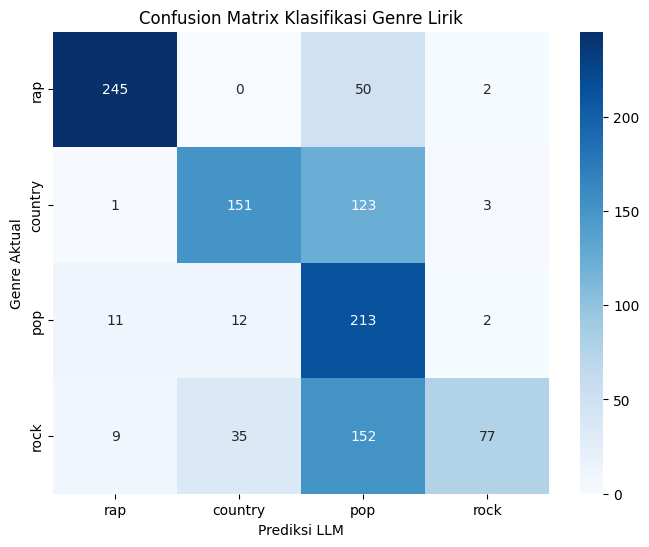

In [ ]:
# Hitung Confusion Matrix
cm = confusion_matrix(df_bersih['genre'], df_bersih['genre_prediksi'], labels=GENRES_VALID)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENRES_VALID, yticklabels=GENRES_VALID)
plt.title('Confusion Matrix Klasifikasi Genre Lirik')
plt.xlabel('Prediksi LLM')
plt.ylabel('Genre Aktual')
plt.show() #

In [ ]:
# Classification Report
report = classification_report(df_bersih['genre'], df_bersih['genre_prediksi'],
                               labels=GENRES_VALID, target_names=GENRES_VALID, output_dict=True)

df_report = pd.DataFrame(report).transpose()
print("\n--- Classification Report Per Genre ---")
print(df_report)


--- Classification Report Per Genre ---
              precision    recall  f1-score      support
rap            0.921053  0.824916  0.870337   297.000000
country        0.762626  0.543165  0.634454   278.000000
pop            0.395911  0.894958  0.548969   238.000000
rock           0.916667  0.282051  0.431373   273.000000
accuracy       0.631676  0.631676  0.631676     0.631676
macro avg      0.749064  0.636273  0.621283  1086.000000
weighted avg   0.764309  0.631676  0.629178  1086.000000


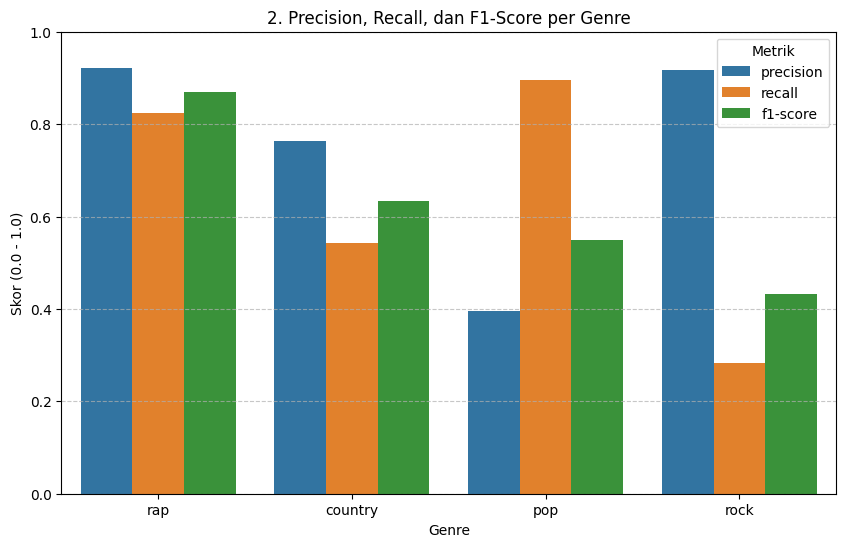

In [ ]:
# pakai df_report sebelumnya
df_metrics = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])[['precision', 'recall', 'f1-score']]
df_metrics = df_metrics.reset_index().rename(columns={'index': 'Genre'})

# Gabungkan data untuk plotting
df_plot = df_metrics.melt(id_vars='Genre', var_name='Metrik', value_name='Nilai')

# Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Nilai', hue='Metrik', data=df_plot)
plt.title('2. Precision, Recall, dan F1-Score per Genre')
plt.ylim(0, 1)
plt.ylabel('Skor (0.0 - 1.0)')
plt.xlabel('Genre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik')
plt.show() #